In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
np.random.seed(42)

n_samples = 100
mean0, var0 = [-2, -2], 1
mean1, var1 = [2, 2], 0.5

# Generate Class 0
X0 = np.random.multivariate_normal(mean0, np.eye(2) * var0, n_samples)
y0 = np.zeros(n_samples)

# Generate Class 1
X1 = np.random.multivariate_normal(mean1, np.eye(2) * var1, n_samples)
y1 = np.ones(n_samples)

# Combine and add bias term (column of 1s)
X = np.vstack((X0, X1))
y = np.concatenate((y0, y1))
X_bias = np.hstack([np.ones((X.shape[0], 1)), X])

In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_loss(X, y, theta):
    m = len(y)
    h = sigmoid(X @ theta)
    epsilon = 1e-15  # prevent log(0)
    loss = -(1/m) * np.sum(y * np.log(h + epsilon) + (1 - y) * np.log(1 - h + epsilon))
    return loss

def gradient_descent(X, y, lr=0.1, epochs=1000):
    m, n = X.shape
    theta = np.zeros(n)
    loss_history = []

    for _ in range(epochs):
        predictions = sigmoid(X @ theta)
        gradient = (1/m) * (X.T @ (predictions - y))
        theta -= lr * gradient
        loss_history.append(compute_loss(X, y, theta))
        
    return theta, loss_history

# Train the model
theta_final, losses = gradient_descent(X_bias, y)

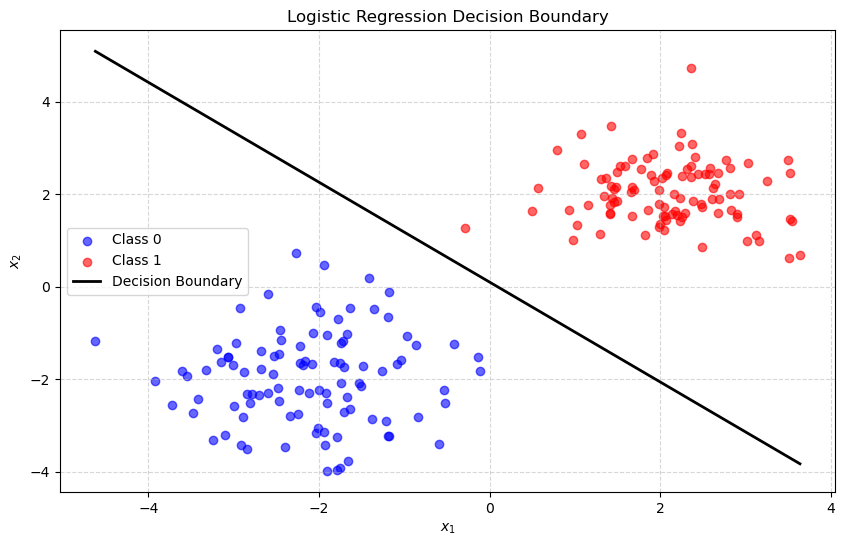

In [9]:
plt.figure(figsize=(10, 6))

# Plot clusters
plt.scatter(X0[:, 0], X0[:, 1], color='blue', label='Class 0', alpha=0.6)
plt.scatter(X1[:, 0], X1[:, 1], color='red', label='Class 1', alpha=0.6)

# Plot Decision Boundary
x1_vals = np.array([np.min(X[:, 0]), np.max(X[:, 0])])
x2_vals = -(theta_final[0] + theta_final[1] * x1_vals) / theta_final[2]

plt.plot(x1_vals, x2_vals, color='black', lw=2, label='Decision Boundary')

plt.title("Logistic Regression Decision Boundary")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [11]:
def train_sgd(X, y, batch_size, lr=0.1, epochs=50):
    m, n = X.shape
    theta = np.zeros(n)
    loss_history = []
    acc_history = []

    for epoch in range(epochs):
        indices = np.random.permutation(m)
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        
        for i in range(0, m, batch_size):
            xi = X_shuffled[i:i+batch_size]
            yi = y_shuffled[i:i+batch_size]
            
            predictions = sigmoid(xi @ theta)
            gradient = (1/len(yi)) * (xi.T @ (predictions - yi))
            theta -= lr * gradient
            
        current_loss = compute_loss(X, y, theta)
        preds_all = (sigmoid(X @ theta) >= 0.5).astype(int)
        accuracy = np.mean(preds_all == y)
        
        loss_history.append(current_loss)
        acc_history.append(accuracy)
        
    return loss_history, acc_history

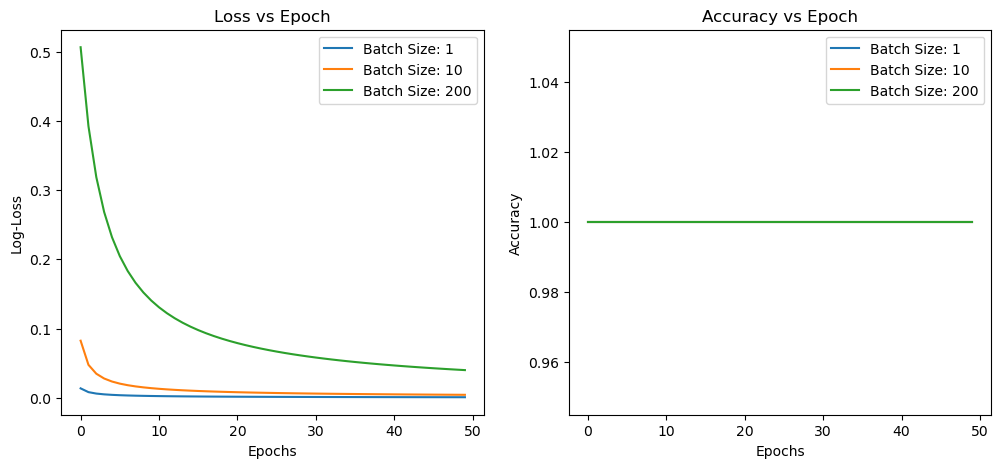

In [12]:
batch_sizes = [1, 10, len(y)]
results = {}

for b in batch_sizes:
    results[b] = train_sgd(X_bias, y, batch_size=b)

# Plotting Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for b in batch_sizes:
    plt.plot(results[b][0], label=f'Batch Size: {b}')
plt.title('Loss vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Log-Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
for b in batch_sizes:
    plt.plot(results[b][1], label=f'Batch Size: {b}')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
def evaluate_model(X, y, theta, threshold=0.5):
    probs = sigmoid(X @ theta)
    
    y_pred = (probs >= threshold).astype(int)
    
    tp = np.sum((y == 1) & (y_pred == 1))
    tn = np.sum((y == 0) & (y_pred == 0))
    fp = np.sum((y == 0) & (y_pred == 1))
    fn = np.sum((y == 1) & (y_pred == 0))
    
    accuracy = (tp + tn) / len(y)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        "Threshold": threshold,
        "Matrix (TP,FP,FN,TN)": (tp, fp, fn, tn),
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    }

In [14]:
thresholds = [0.3, 0.5, 0.7]
evaluations = []

for t in thresholds:
    res = evaluate_model(X_bias, y, theta_final, threshold=t)
    evaluations.append(res)

# Visualizziamo i risultati in una tabella semplice
import pandas as pd
df = pd.DataFrame(evaluations)
print(df.to_string(index=False))

 Threshold Matrix (TP,FP,FN,TN)  Accuracy  Precision  Recall  F1-Score
       0.3     (100, 0, 0, 100)       1.0        1.0     1.0       1.0
       0.5     (100, 0, 0, 100)       1.0        1.0     1.0       1.0
       0.7     (100, 0, 0, 100)       1.0        1.0     1.0       1.0


In [17]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "diabetes.csv"

df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "uciml/pima-indians-diabetes-database",
  file_path,
)

# Extract features and labels
X_raw = df.drop('Outcome', axis=1).values
y = df['Outcome'].values

# Standardize features: (X - mean) / std
mean_X = np.mean(X_raw, axis=0)
std_X = np.std(X_raw, axis=0)
X_scaled = (X_raw - mean_X) / std_X

# Add Bias term (column of 1s)
m = X_scaled.shape[0]
X = np.hstack([np.ones((m, 1)), X_scaled])

c:\Users\weiji\anaconda3\envs\SMM\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\weiji\AppData\Local\Temp\ipykernel_32004\1274982451.py:6: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


100%|██████████| 23.3k/23.3k [00:00<00:00, 525kB/s]


In [18]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_loss(theta, X, y):
    m = len(y)
    h = sigmoid(X @ theta)
    epsilon = 1e-15
    return -(1/m) * np.sum(y * np.log(h + epsilon) + (1 - y) * np.log(1 - h + epsilon))

def compute_grad(theta, X, y):
    m = len(y)
    h = sigmoid(X @ theta)
    return (1/m) * (X.T @ (h - y))

def compute_accuracy(theta, X, y):
    preds = (sigmoid(X @ theta) >= 0.5).astype(int)
    return np.mean(preds == y)

def train_sgd(X, y, lr=1e-3, epochs=200, batch_size=32):
    m, d = X.shape
    theta = np.zeros(d)
    losses, accs = [], []
    
    for epoch in range(epochs):
        # Shuffle
        indices = np.random.permutation(m)
        X_shuff, y_shuff = X[indices], y[indices]
        
        for i in range(0, m, batch_size):
            Xi = X_shuff[i:i+batch_size]
            yi = y_shuff[i:i+batch_size]
            
            # Gradient Step
            grad = compute_grad(theta, Xi, yi)
            theta -= lr * grad
            
        # Log metrics (Full Dataset)
        losses.append(compute_loss(theta, X, y))
        accs.append(compute_accuracy(theta, X, y))
        
    return theta, losses, accs

def train_adam(X, y, lr=1e-3, epochs=200, batch_size=32, beta1=0.9, beta2=0.999, eps=1e-8):
    m, d = X.shape
    theta = np.zeros(d)
    mt = np.zeros(d) # First moment
    vt = np.zeros(d) # Second moment
    t = 0
    
    losses, accs = [], []
    
    for epoch in range(epochs):
        indices = np.random.permutation(m)
        X_shuff, y_shuff = X[indices], y[indices]
        
        for i in range(0, m, batch_size):
            Xi = X_shuff[i:i+batch_size]
            yi = y_shuff[i:i+batch_size]
            
            grad = compute_grad(theta, Xi, yi)
            t += 1
            
            # Update moments
            mt = beta1 * mt + (1 - beta1) * grad
            vt = beta2 * vt + (1 - beta2) * (grad ** 2)
            
            # Bias correction
            m_hat = mt / (1 - beta1 ** t)
            v_hat = vt / (1 - beta2 ** t)
            
            # Update parameters
            theta -= lr * m_hat / (np.sqrt(v_hat) + eps)
            
        losses.append(compute_loss(theta, X, y))
        accs.append(compute_accuracy(theta, X, y))
        
    return theta, losses, accs

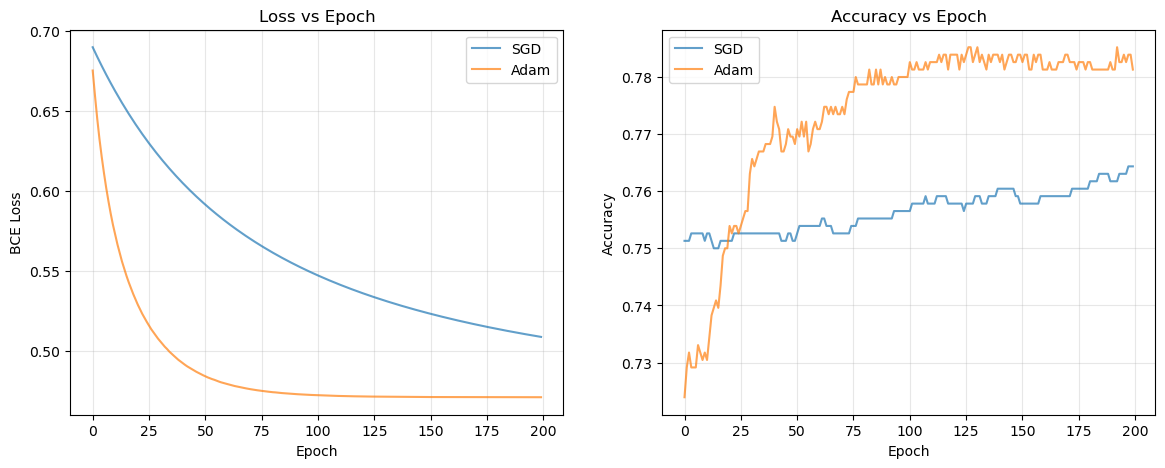

In [20]:
theta_sgd, loss_sgd, acc_sgd = train_sgd(X, y, lr=1e-3, epochs=200, batch_size=32)
theta_adam, loss_adam, acc_adam = train_adam(X, y, lr=1e-3, epochs=200, batch_size=32)


plt.figure(figsize=(14, 5))

# Loss Comparison
plt.subplot(1, 2, 1)
plt.plot(loss_sgd, label='SGD', alpha=0.7)
plt.plot(loss_adam, label='Adam', alpha=0.7)
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('BCE Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy Comparison
plt.subplot(1, 2, 2)
plt.plot(acc_sgd, label='SGD', alpha=0.7)
plt.plot(acc_adam, label='Adam', alpha=0.7)
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

In [21]:
def get_metrics(name, theta, X, y):
    preds = (sigmoid(X @ theta) >= 0.5).astype(int)
    
    TP = np.sum((preds == 1) & (y == 1))
    TN = np.sum((preds == 0) & (y == 0))
    FP = np.sum((preds == 1) & (y == 0))
    FN = np.sum((preds == 0) & (y == 1))
    
    acc = (TP + TN) / len(y)
    prec = TP / (TP + FP) if (TP+FP) > 0 else 0
    rec = TP / (TP + FN) if (TP+FN) > 0 else 0
    f1 = 2 * (prec * rec) / (prec + rec) if (prec+rec) > 0 else 0
    
    print(f"--- {name} Results ---")
    print(f"Final Accuracy: {acc*100:.2f}%")
    print(f"Confusion Matrix (TP, FP, FN, TN): {TP, FP, FN, TN}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall:    {rec:.3f}")
    print(f"F1 Score:  {f1:.3f}\n")

get_metrics("SGD", theta_sgd, X, y)
get_metrics("Adam", theta_adam, X, y)

--- SGD Results ---
Final Accuracy: 76.43%
Confusion Matrix (TP, FP, FN, TN): (np.int64(159), np.int64(72), np.int64(109), np.int64(428))
Precision: 0.688
Recall:    0.593
F1 Score:  0.637

--- Adam Results ---
Final Accuracy: 78.12%
Confusion Matrix (TP, FP, FN, TN): (np.int64(156), np.int64(56), np.int64(112), np.int64(444))
Precision: 0.736
Recall:    0.582
F1 Score:  0.650

